### What are the median decision times for Sam, Blanche?

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

In [3]:
num_bins = 10

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    med = beh.BeliefStateValue.median()
    beh["BeliefStateValueBin"] = beh.apply(lambda x: 0 if x.BeliefStateValue < med else 1, axis=1)
    beh["PreferredBelief"] = beh[[f"{feat}Prob" for feat in FEATURES]].idxmax(axis=1).apply(lambda x: x[:-4])
    beh["BeliefLabel"] = beh.apply(lambda x: f"High Value Pref {x.PreferredBelief}" if x.BeliefStateValueBin == 1 else "Low Value", axis=1)
    beh["session"] = session
    return beh

In [4]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
res["CombinedIdx"] = np.arange(len(res))

In [5]:
res["DecisionTime"] = res["FeedbackOnset"] - 800 - res["StimOnset"]

### Histogram of decision times: 

<Axes: >

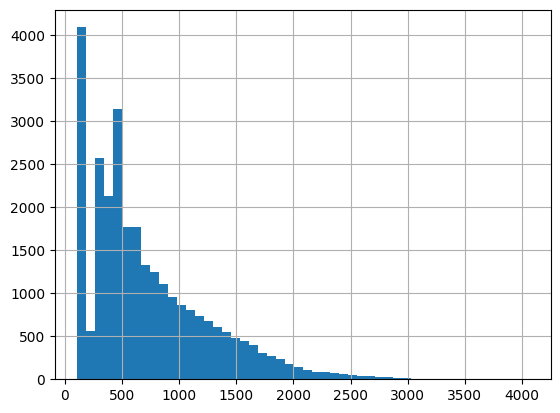

In [6]:
res["DecisionTime"].hist(bins=50)

### Hist of decision times when removing < 150ms decisions

<Axes: >

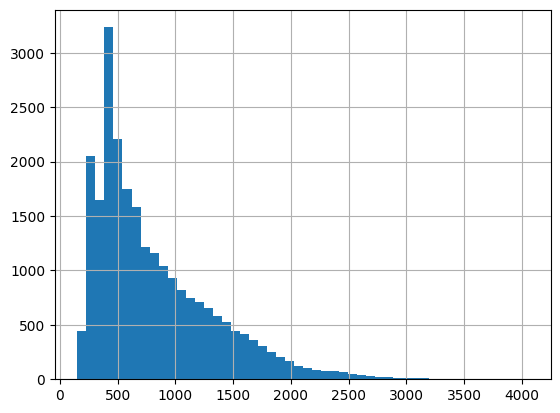

In [7]:
sub_res = res[res.DecisionTime > 150]
sub_res["DecisionTime"].hist(bins=50)

<Axes: >

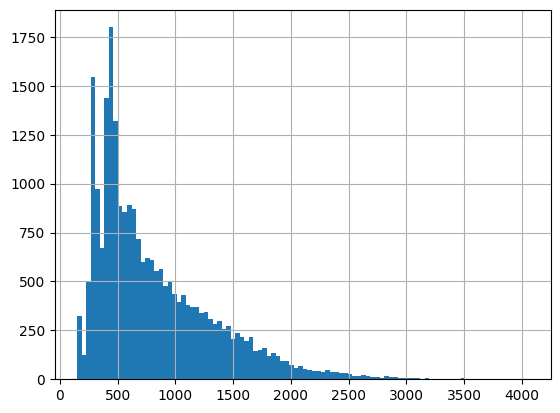

In [8]:
sub_res["DecisionTime"].hist(bins=100)

### Does it look log normal?

<Axes: >

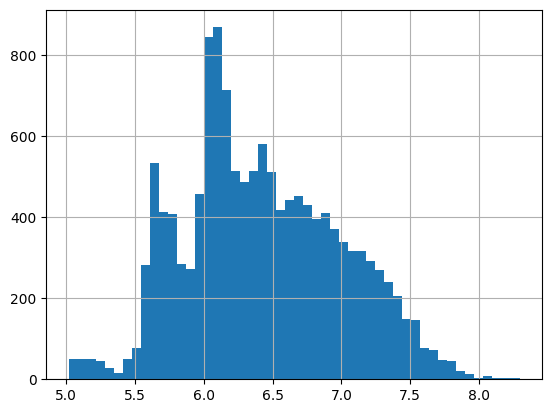

In [21]:
sub_res["LogDecisionTime"] = np.log(sub_res["DecisionTime"])
sub_res["LogDecisionTime"].hist(bins=50)

### Is there any bias in terms of when these <150ms decisions occur? Relative to BSV?
Decisions of <150ms seem fairly uniformly distributed amongst BSV, probably fair to remove them

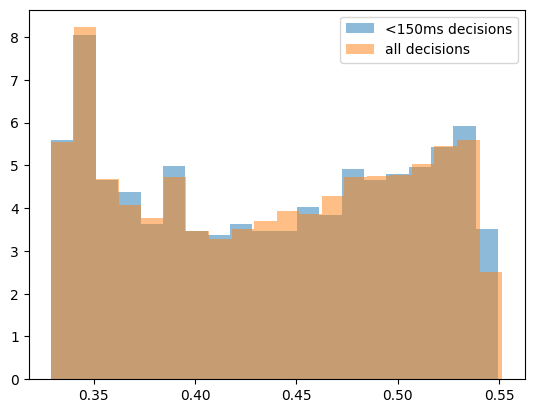

In [9]:
shorts = res[res.DecisionTime < 150]
fig, ax = plt.subplots()
ax.hist(shorts.BeliefStateValue, density=True, stacked=True, bins=20, alpha=0.5, label="<150ms decisions")
ax.hist(res.BeliefStateValue, density=True, stacked=True, bins=20, alpha=0.5, label="all decisions")
ax.legend()

### What do different decision time distributions look like depending on value? 

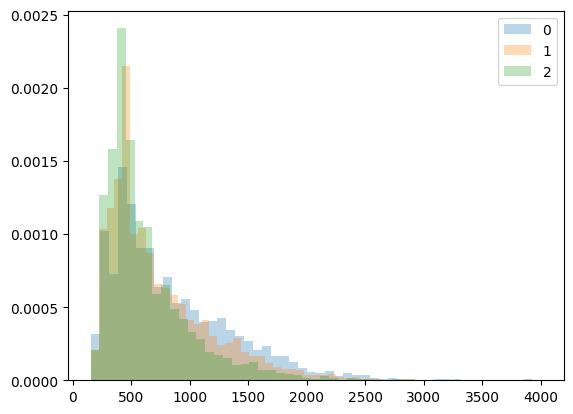

In [20]:
# split by median
sub_res = res[res.DecisionTime > 150]
sub_res = sub_res[sub_res.Response == "Correct"]
num_bins = 3
sub_res["BeliefStateValueBinX"] = pd.qcut(sub_res.BeliefStateValue, num_bins, labels=False)
fig, ax = plt.subplots()
for bin_idx in range(num_bins):
    bin_res = sub_res[sub_res.BeliefStateValueBinX == bin_idx]
    ax.hist(bin_res.DecisionTime, density=True, stacked=True, bins=50, alpha=0.3, label=bin_idx)
ax.legend()

### Any bias in feature dimensions?

### For Sam, a good round number of median would be 700

In [33]:
res.DecisionTime.median()

570.0

In [35]:
sub_res.DecisionTime.median()

655.0

### What about for Blanche

In [39]:
# Monkey B
SESSIONS_PATH = "/data/patrick_res/sessions/BL/valid_sessions_61.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = BL_SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
res["CombinedIdx"] = np.arange(len(res))
res["DecisionTime"] = res["FeedbackOnset"] - 800 - res["StimOnset"]

<Axes: >

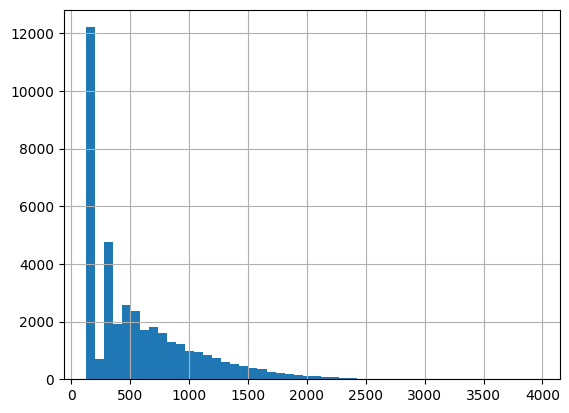

In [40]:
res["DecisionTime"].hist(bins=50)


<Axes: >

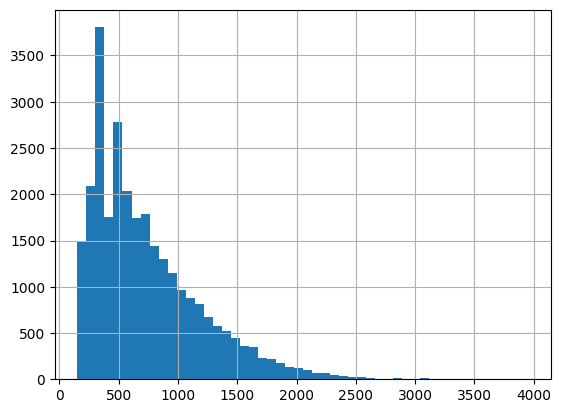

In [44]:
sub_res = res[res.DecisionTime > 150]
sub_res.DecisionTime.hist(bins=50)

In [46]:
sub_res.DecisionTime.median()

616.0

### Seems like 600 would be a reasonable median for both Sam/Blanche

### Scrap code to help with the time warping

In [1]:
import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import os

SPECIES = 'nhp'
SUBJECT = 'SA'

DECISION_MEDIAN = 600

PRE_INTERVAL = 0
POST_INTERVAL = DECISION_MEDIAN
INTERVAL_SIZE = 50
NUM_BINS_SMOOTH = 1
EVENT = "decision"
sess_name = 20180802

behavior_path = f"/data/patrick_res/behavior/{SUBJECT}/{sess_name}_object_features.csv"
beh = pd.read_csv(behavior_path)
valid_beh = beh[beh.Response.isin(["Correct", "Incorrect"])]
spike_times = spike_general.get_spike_times(None, SUBJECT, sess_name, species_dir="/data")

print("Calculating spikes by trial interval")
interval_size_secs = INTERVAL_SIZE / 1000
intervals = pd.DataFrame({
    "TrialNumber": valid_beh["TrialNumber"], 
    "IntervalStartTime": valid_beh["StimOnset"],
    "IntervalEndTime": valid_beh["FeedbackOnset"] - 800,
    "Duration": valid_beh["FeedbackOnset"] - 800 - valid_beh["StimOnset"]
})
intervals["scale"] = DECISION_MEDIAN / intervals["Duration"]

spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)
spike_by_trial_interval["TrialNumber"] = spike_by_trial_interval["TrialNumber"].astype(int)
spike_by_trial_interval = pd.merge(spike_by_trial_interval, intervals, on="TrialNumber")
spike_by_trial_interval["RelativeSpikeTime"] = spike_by_trial_interval.SpikeTime - spike_by_trial_interval.IntervalStartTime
all_units = spike_general.list_session_units(None, SUBJECT, sess_name, species_dir="/data")

Calculating spikes by trial interval


In [2]:
def warp_spike_times(spikes_in_trial):
    scale = spikes_in_trial.scale.iloc[0]
    spikes_in_trial["SpikeTime"] = spikes_in_trial.RelativeSpikeTime * scale + spikes_in_trial.IntervalStartTime
    return spikes_in_trial

warped = spike_by_trial_interval.groupby("TrialNumber", group_keys=False).apply(warp_spike_times).reset_index(drop=True)

In [3]:
warped

,UnitID,SpikeTime,TrialNumber,SpikeTimeFromStart,IntervalStartTime,IntervalEndTime,Duration,scale,RelativeSpikeTime
0,5,754531.0,0,0.0,754531.0,754788.0,257.0,2.334630,0.0
1,9,754533.33463,0,1.0,754531.0,754788.0,257.0,2.334630,1.0
2,5,754535.669261,0,2.0,754531.0,754788.0,257.0,2.334630,2.0
3,27,754561.350195,0,13.0,754531.0,754788.0,257.0,2.334630,13.0
4,9,754568.354086,0,16.0,754531.0,754788.0,257.0,2.334630,16.0
...,...,...,...,...,...,...,...,...,...
304982,10,13685964.243243,1749,134.0,13685421.0,13685569.0,148.0,4.054054,134.0
304983,0,13685976.405405,1749,137.0,13685421.0,13685569.0,148.0,4.054054,137.0
304984,17,13685988.567568,1749,140.0,13685421.0,13685569.0,148.0,4.054054,140.0
304985,27,13686004.783784,1749,144.0,13685421.0,13685569.0,148.0,4.054054,144.0


In [4]:
end_bin = (PRE_INTERVAL + POST_INTERVAL) / 1000 + interval_size_secs

firing_rates = spike_analysis.firing_rate(
    warped, 
    all_units, 
    bins=np.arange(0, end_bin, interval_size_secs), 
    smoothing=NUM_BINS_SMOOTH,
    trials=valid_beh.TrialNumber.unique()
)

In [5]:
firing_rates = pd.merge(firing_rates, intervals[["TrialNumber", "scale"]], on="TrialNumber")
firing_rates["FiringRate"] = firing_rates.FiringRate / firing_rates.scale

In [40]:
firing_rates["scale"].min()

0.15286624203821655

In [6]:
firing_rates

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate,scale
0,0,0,0.00,0.0,0.500490,2.334630
1,0,0,0.05,0.0,2.074035,2.334630
2,0,0,0.10,1.0,3.417616,2.334630
3,0,0,0.15,0.0,2.072889,2.334630
4,0,0,0.20,0.0,0.462524,2.334630
...,...,...,...,...,...,...
965443,1749,45,0.35,0.0,0.000000,4.054054
965444,1749,45,0.40,0.0,0.000000,4.054054
965445,1749,45,0.45,0.0,0.000000,4.054054
965446,1749,45,0.50,0.0,0.000000,4.054054
